In [1]:
# Import necessary modules
# We will use numpy for array management and computing FFTs
import numpy as np
# We will use mathplotlib for plotting
import matplotlib.pyplot as plt

# Used https://en.wikipedia.org/wiki/Harmonic_oscillator for force formula
#### #### #### ####*#### #### #### ####*#### #### #### ####*#### #### #### ####*

In [2]:
def run_sim(n = 10000, time = 40, m = 1, k = 100, c = 1, x0 = 0, v0 = 0,
            sigma = 1):
    """
    Simulates a harmonic oscillator with mass m and spring constant k for a
    period of time time broken down into n intervals. The thermal noise (F_T)
    is modeled as a Gaussian centered at 0 with standard deviation sigma. The
    harmonic oscillator starts with displacement x0 and velocity v0. c
    controls the damping.

    Returned are the values of all the initial parameters as well as the
    computed time interval (dt) as well as the position (x), velocity (v),
    thermal force (F_T), and total force (F_total) for all time intervals.
    """

    # Generates an array of all times
    t = np.linspace(0, time - time/n, n)
    # Computes the interval between times
    dt = time/n

    # Generates the thermal noise
    rng = np.random.default_rng()
    F_T = rng.normal(size = n, scale = sigma)

    # Creates empty arrays for position, velocity, and total force
    x = np.append(x0, np.empty(n))
    v = np.append(v0, np.empty(n))
    F_total = np.empty(n)

    for i in range(n): # Iterates through each time interval
        # The total force is the sum of the spring force (- k * x), the damping
        # force (-c * v), and the thermal force (F_T)
        F_total[i] = - k * x[i] - c * v[i] + F_T[i]
        # We use the fact that a = F_total / m, dv = a * dt and dx = v * dt to
        # update the velocity and positition
        v[i + 1] = v[i] + F_total[i] / m * dt
        x[i + 1] = x[i] + v[i + 1] / m * dt

    return {"n": n, "time": time, "m": m, "k": k, "c": c, "x0": x0, "v0": v0,
            "dt": dt, "t": t, "x": x[1:], "v": v[1:], "F_T": F_T,
            "F_total": F_total}

In [3]:
label = {
    "x": "Position, $x$",
    "t": "Time, $t$",
    "v": "Velocity, $v$",
    "F_T": "Thermal Force, $F_T$",
    "F_total": "Total Force, $F_\\text{total}$",
    "f": "Frequency, $f$"
}

def basic_plot(parameters, to_plot = ["x", "v", "F_T", "F_total"], cutoff = None):
    """
    to_plot: A list of variables we want to plot against time to iterate
    through later
    parameters: Contains the simulation output
    """
    
    # Set up figure
    fig, ax = plt.subplots(4, sharex = True, figsize=(8,16),
                           layout="constrained")

    if cutoff == None:
        cutoff = parameters["n"]
    
    for i in range(len(to_plot)):
        # Find the variable we'll be plotting and calculate relevant
        # statisitics
        var = to_plot[i]

        # Plots data
        ax[i].plot(parameters["t"][:cutoff], parameters[var][:cutoff], label=label[var])

        # Makes y-axis label
        ax[i].set(ylabel=label[var])

    # Makes the label on the x-axis
    ax[-1].set(xlabel=label["t"],
               xlim = [0, parameters["time"] * (cutoff/parameters["n"])])

def fft_plot(parameters, to_plot = ["x", "v", "F_T", "F_total"]):
    """
    to_plot: A list of variables we want to plot against time to iterate
    through later
    parameters: Contains the simulation output
    """
    
    # Set up figure
    fig, ax = plt.subplots(4, 2, sharex = "col", figsize=(8,16),
                           layout="constrained")

    # Expected frequency of the harmonic oscillator
    exp_f = np.sqrt(parameters["k"]/parameters["m"]) / (2 * np.pi)
    
    
    for i in range(len(to_plot)):
        # Find the variable we'll be plotting and calculate relevant
        # statisitics
        var = to_plot[i]
        m = np.mean(parameters[var])
        std = np.std(parameters[var], ddof = 1)

        # Plots data along with horizontal lines at mean and mean +- standard
        # deviation
        ax[i][0].plot(parameters["t"], parameters[var], label=label[var])
        ax[i][0].hlines(y = m + std, xmin = 0, xmax = parameters["time"], colors = "C1", label=f"m + std = {m + std:.3}")
        ax[i][0].hlines(y = m, xmin = 0, xmax = parameters["time"], colors = "C2", label=f"m = {m:.3}")
        ax[i][0].hlines(y = m - std, xmin = 0, xmax = parameters["time"], colors = "C1", label=f"m - std = {m - std:.3}")

        fft = np.abs(np.fft.rfft(parameters[var]))
        f = np.linspace(0, (parameters["n"]//2)/parameters["time"],
                        parameters["n"]//2 + 1)
        ax[i][1].plot(f, fft, label="FFT Results")
        window = np.kaiser(51, 14)
        ax[i][1].plot(f, np.convolve(fft, window/np.sum(window), 'same'), label="Moving average")
        ax[i][1].vlines(x = exp_f, ymin = 0, ymax = np.max(fft), colors = "C2", label="$\\frac{1}{2\pi} \sqrt{\\frac{k}{m}}$")
        
        # Makes y-axis label
        ax[i][0].set(ylabel=label[var])
        ax[i][1].set(ylim = [0, np.max(fft)])
        ax[i][0].legend(loc="upper right")
        ax[i][1].legend(loc="upper right")

    # Makes the label on the x-axis
    ax[-1][0].set(xlabel=label["t"], xlim = [0, parameters["time"]])
    ax[-1][1].set(xlabel=label["f"], xlim = [0, exp_f * 2])

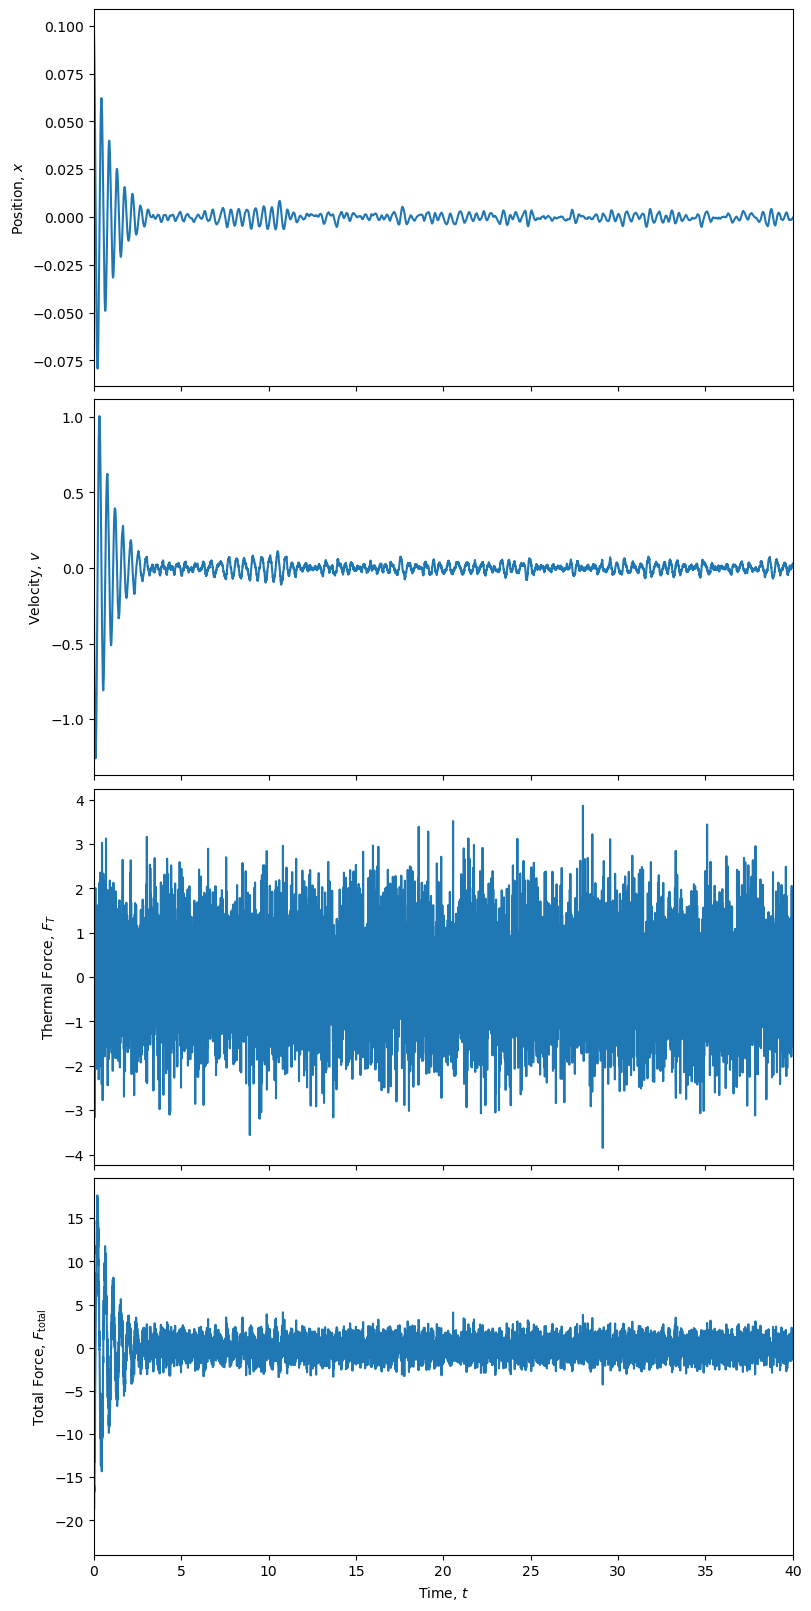

In [4]:
# These parameters are chosen so that you really see the ringing down and the
# subsequent "packets" of waves.

parameters = run_sim(x0 = 0.1, c = 2, k = 200)

basic_plot(parameters)

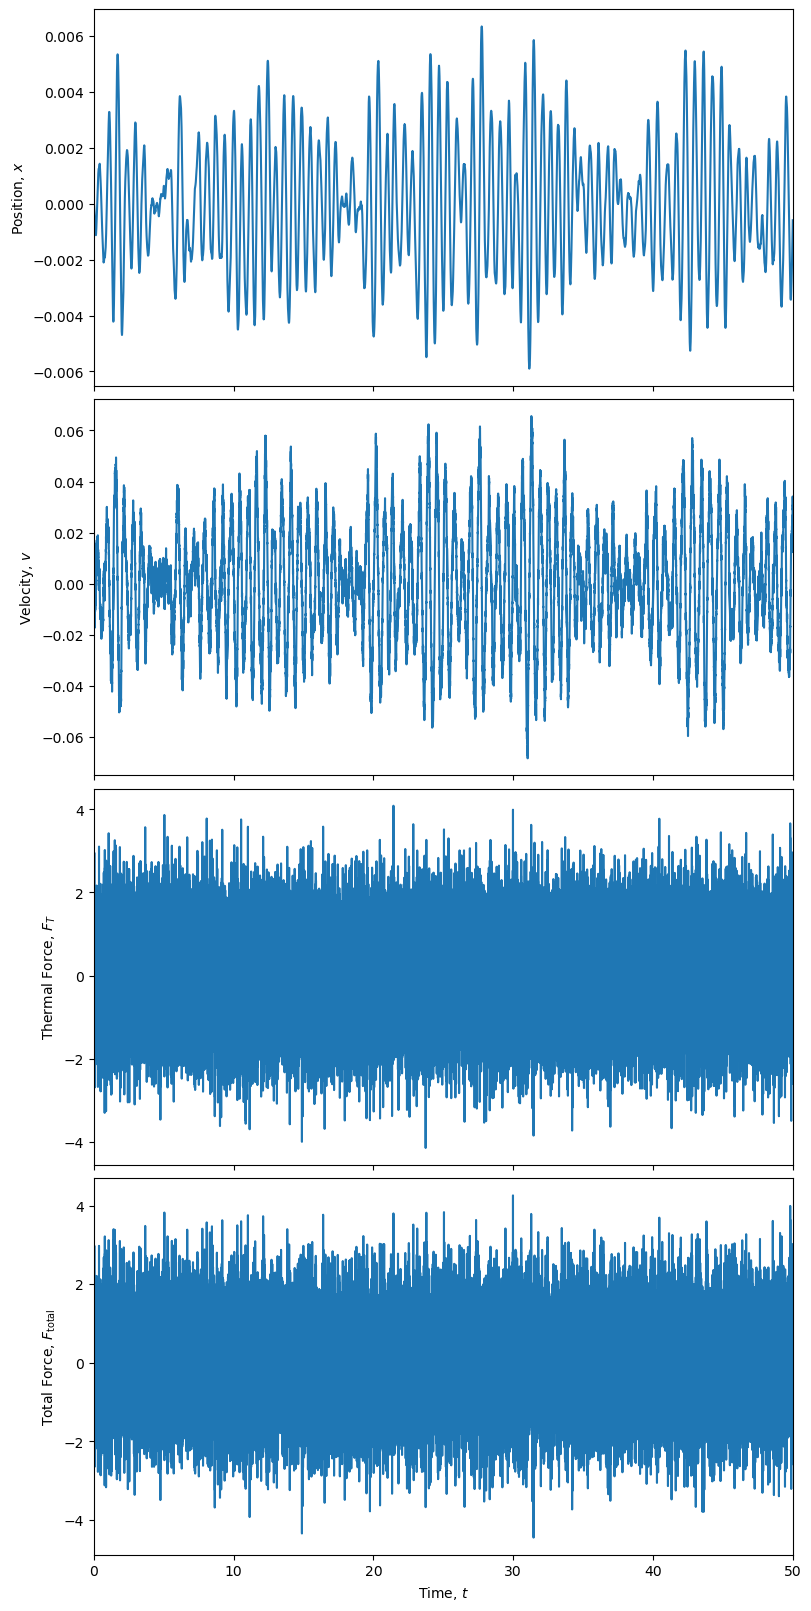

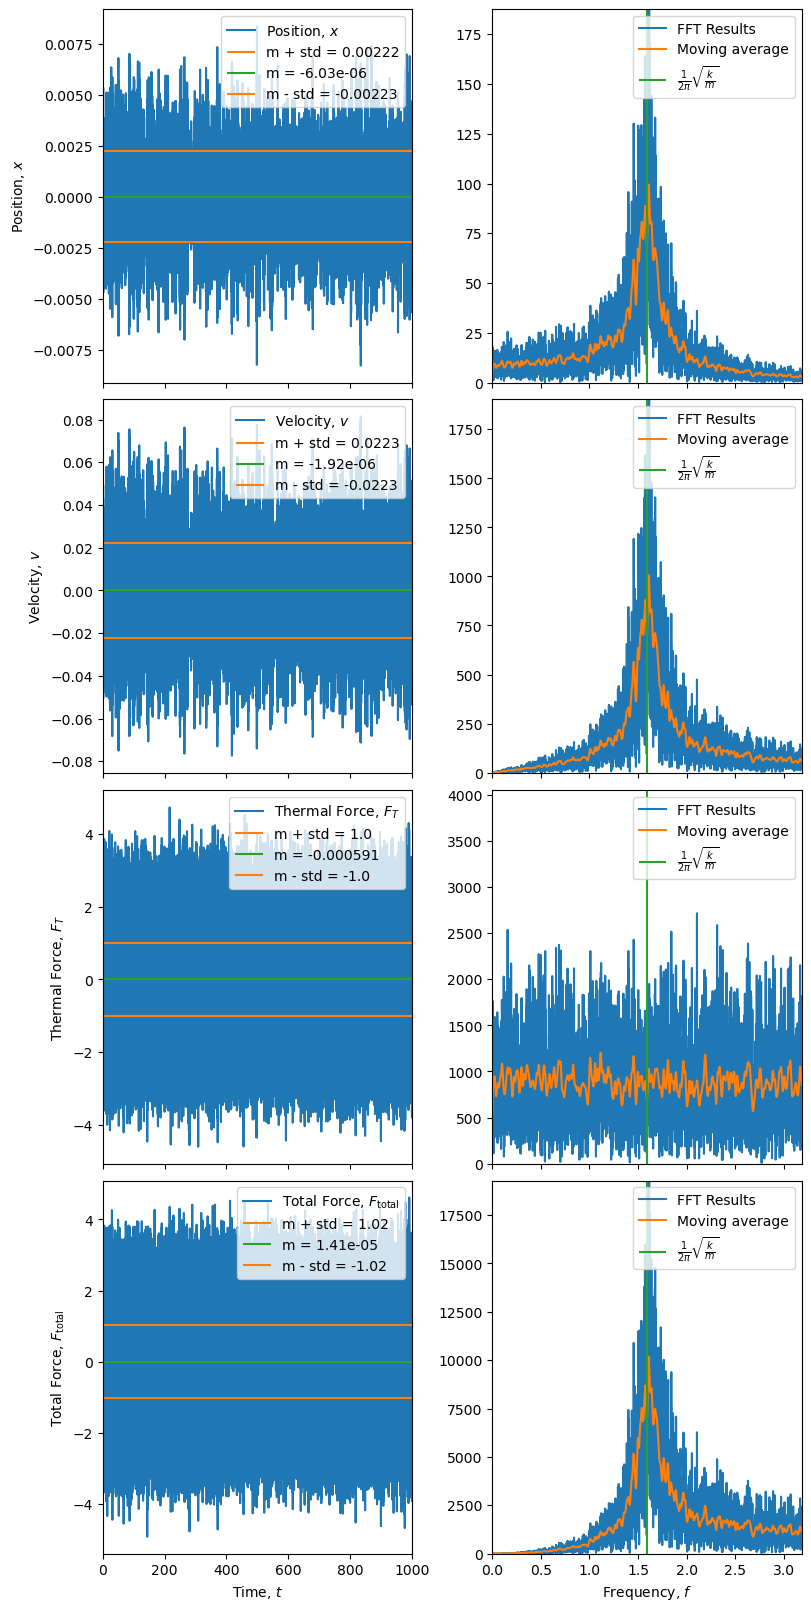

In [5]:
# These parameters are chosen so that we get a nice Fourier transform

parameters = run_sim(time = 1000, n = 1000000)

# Shows first 5% of the data so that we actually see what's going on
basic_plot(parameters, cutoff = 50000)

# Plots all data and FFT transforms
fft_plot(parameters)